In [71]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, roc_auc_score, plot_roc_curve, f1_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [72]:
import pandas as pd
LoanStatData = pd.read_csv('./Loan_status_2007-2020Q3.gzip')
#Checking the data if it loaded or not.
LoanStatData.info

/var/folders/sk/qnqfmc1n43xcb8gqr40z974c0000gn/T/ipykernel_2042/893594257.py:2: DtypeWarning:

Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.



<bound method DataFrame.info of          Unnamed: 0         id  loan_amnt  funded_amnt  funded_amnt_inv  \
0                 0    1077501     5000.0       5000.0           4975.0   
1                 1    1077430     2500.0       2500.0           2500.0   
2                 2    1077175     2400.0       2400.0           2400.0   
3                 3    1076863    10000.0      10000.0          10000.0   
4                 4    1075358     3000.0       3000.0           3000.0   
...             ...        ...        ...          ...              ...   
2925488      105446  102556443    24000.0      24000.0          24000.0   
2925489      105447  102653304    10000.0      10000.0          10000.0   
2925490      105448  102628603    10050.0      10050.0          10050.0   
2925491      105449  102196576     6000.0       6000.0           6000.0   
2925492      105450   99799684    30000.0      30000.0          30000.0   

               term int_rate  installment grade sub_grade  ...  \
0

In [73]:
LoanStatData = LoanStatData.sample(20000)
#Check for any NaN values that affect the dataset
print('Number of rows in each column affected by existence of non-existing values:')

Number of rows in each column affected by existence of non-existing values:


In [74]:
LoanStatData = LoanStatData[LoanStatData['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

In [75]:
#creating a column for the year in the data set
LoanStatData['year'] = pd.to_datetime(LoanStatData['issue_d']).dt.year
LoanStatData.columns.values


array(['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_co

In [76]:
LoanStatData.head()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,year
2806971,83708,96539718,30000.0,30000.0,30000.0,36 months,10.49%,974.94,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2017
2473297,50554,78499509,20000.0,20000.0,20000.0,36 months,11.99%,664.20,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2016
2278048,410287,38567544,14600.0,14600.0,14600.0,36 months,17.14%,521.55,D,D4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,2015
560869,88803,127023221,2700.0,2700.0,2700.0,36 months,19.03%,99.02,D,D3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2018
2105563,237802,53282803,21000.0,21000.0,21000.0,60 months,12.69%,474.49,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2015


<AxesSubplot:xlabel='fico_range_low', ylabel='fico_range_high'>

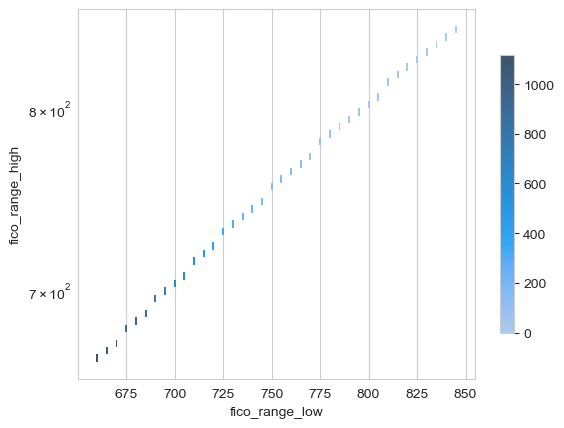

In [77]:
#creating FICO for the setting range
LoanStatData['fico'] = LoanStatData.apply(lambda r: (r.fico_range_low + r.fico_range_high) / 2, axis=1)
sns.histplot(
    LoanStatData, x="fico_range_low", y="fico_range_high",
    discrete=(True, False), log_scale=(False, True),
    cbar=True, cbar_kws=dict(shrink=.75,),
)

<AxesSubplot:xlabel='loan_amnt'>

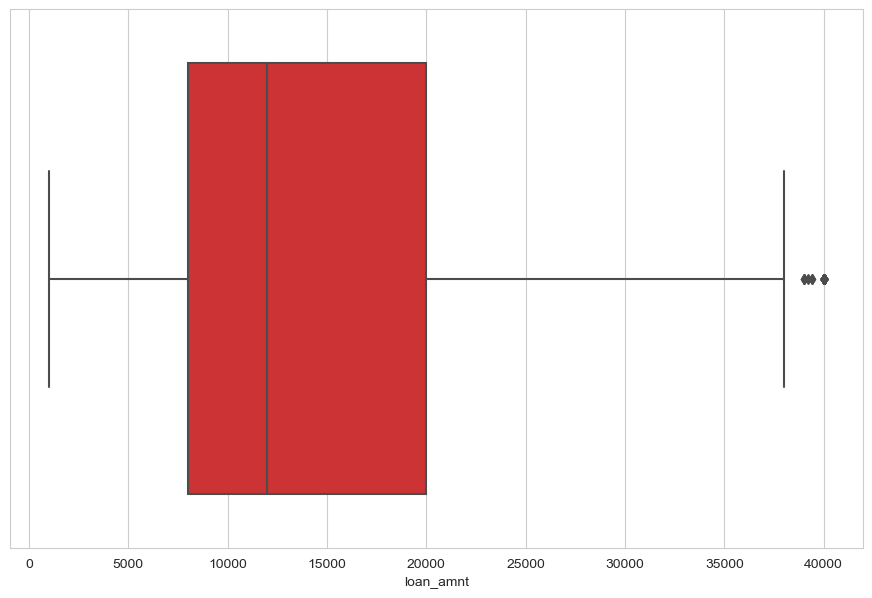

In [78]:

plt.figure(figsize=(11,7))
sns.boxplot(x='loan_amnt',data=LoanStatData,palette='Set1')

[Text(0.5, 1.0, 'Taking new loans to pay for other assets is loan debt consolidation ')]

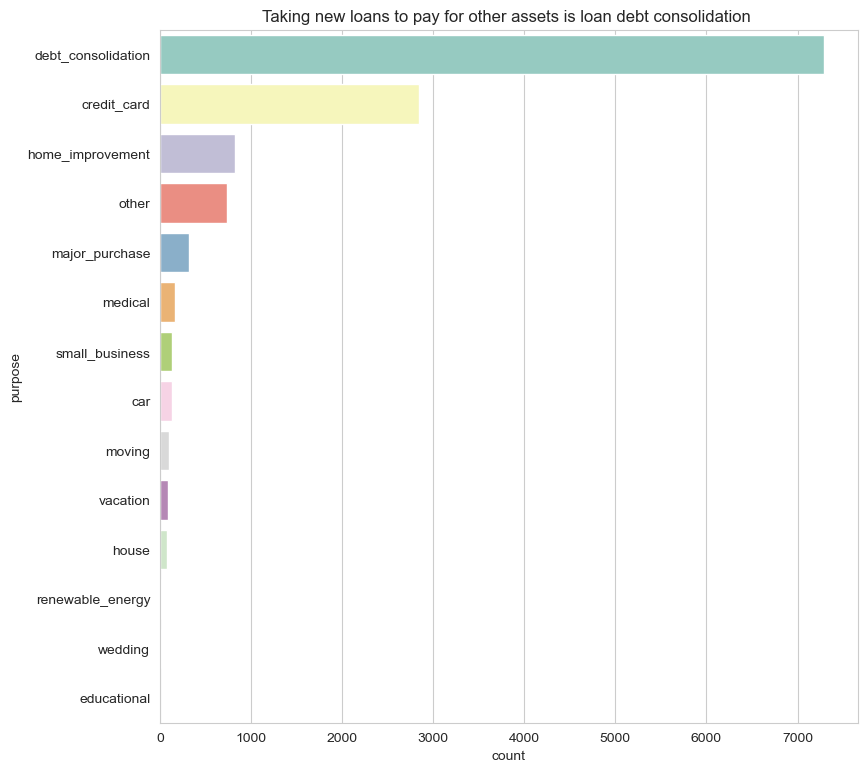

In [79]:
plt.figure(figsize=(9,9))
ax = sns.countplot(y="purpose", data=LoanStatData, palette="Set3",
                   order=LoanStatData['purpose'].value_counts().index,
                   dodge=False)
ax.set(title="Taking new loans to pay for other assets is loan debt consolidation ")

In [80]:
#maximum amount of loans in the dataset are four states that are from California, Texas, New York and Florida.
#finding frequency of loans given to different states
statewise_loan_freq = LoanStatData.groupby(['addr_state'], as_index=False).size()
statewise_loan_freq

,addr_state,size
0,AK,27
1,AL,145
2,AR,87
3,AZ,290
4,CA,1790
5,CO,258
6,CT,181
7,DC,42
8,DE,28
9,FL,929


In [81]:
fig = go.Figure(
    data=go.Choropleth(
        locations=list(statewise_loan_freq['addr_state'].values),
        z = list(statewise_loan_freq['size'].values),
        locationmode = 'USA-states',
        colorscale = 'Rainbow'
    ))

fig.update_layout(
    title_text = 'Offered Loans from different State',
    geo_scope='usa',
)

fig.show()

In [82]:
dti_non_null = LoanStatData[~LoanStatData['dti'].isnull()]

In [83]:
dti_non_null

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,year,fico
2806971,83708,96539718,30000.0,30000.0,30000.0,36 months,10.49%,974.94,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2017,682.0
2473297,50554,78499509,20000.0,20000.0,20000.0,36 months,11.99%,664.20,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2016,662.0
2278048,410287,38567544,14600.0,14600.0,14600.0,36 months,17.14%,521.55,D,D4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,2015,687.0
560869,88803,127023221,2700.0,2700.0,2700.0,36 months,19.03%,99.02,D,D3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2018,712.0
2105563,237802,53282803,21000.0,21000.0,21000.0,60 months,12.69%,474.49,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2015,697.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660451,175036,14569537,9600.0,9600.0,9600.0,36 months,12.49%,321.11,B,B4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2014,712.0
1679941,194526,12655610,16000.0,16000.0,16000.0,60 months,23.43%,455.01,F,F1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2014,667.0
2722837,103120,90114693,6500.0,6500.0,6500.0,36 months,11.49%,214.32,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2016,662.0
2328901,40045,74702634,12000.0,12000.0,12000.0,60 months,9.16%,250.04,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,2016,667.0


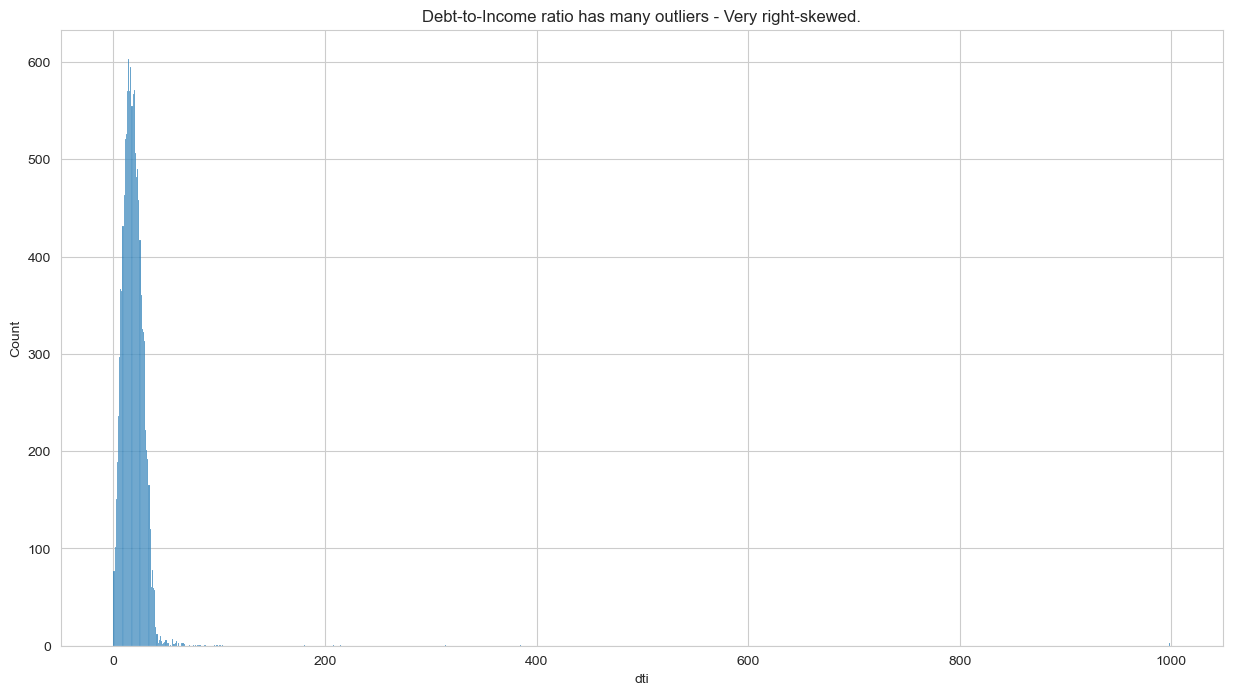

In [84]:
plt.figure(figsize=(15, 8))
ax = sns.histplot(x="dti", data=dti_non_null)
ax.set(title="Debt-to-Income ratio has many outliers - Very right-skewed.")
plt.savefig('Debt-to-Income ratio has many outliers', dpi=300)

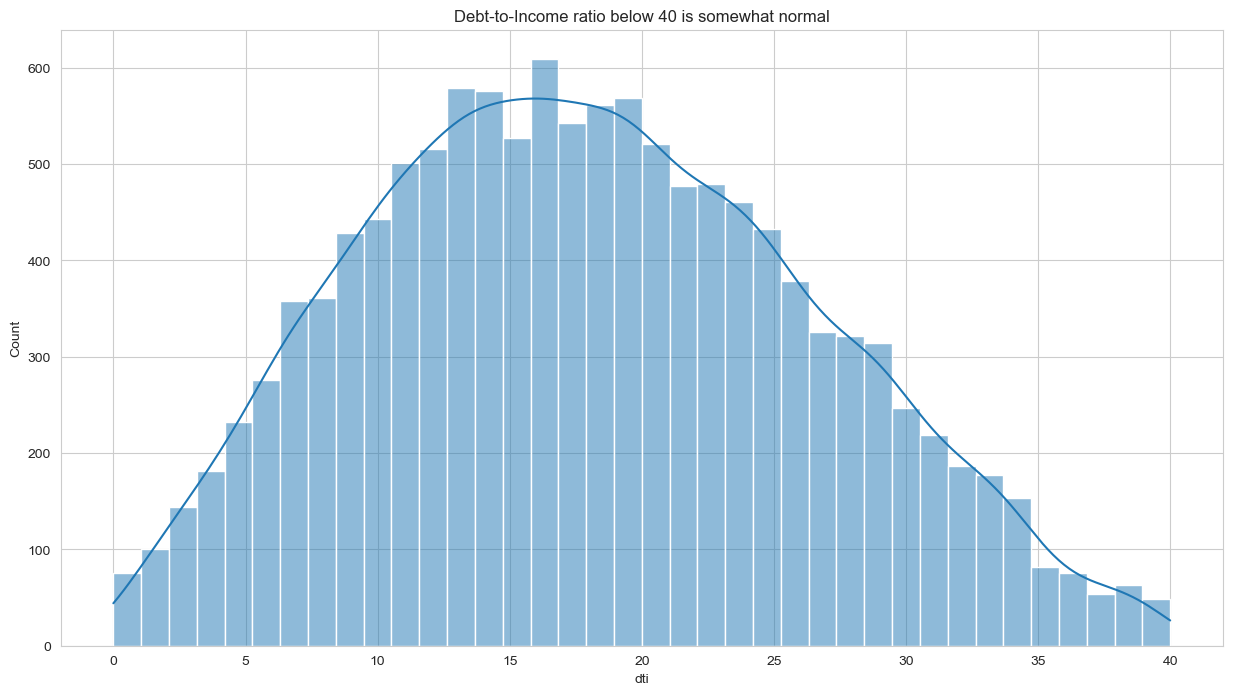

In [85]:
plt.figure(figsize=(15, 8))
ax = sns.histplot(x="dti", kde=True, data=dti_non_null[dti_non_null.dti <= 40])
ax.set(title="Debt-to-Income ratio below 40 is somewhat normal")
plt.savefig('Debt-to-Income ratio below 40 is somewhat normal', dpi= 300)

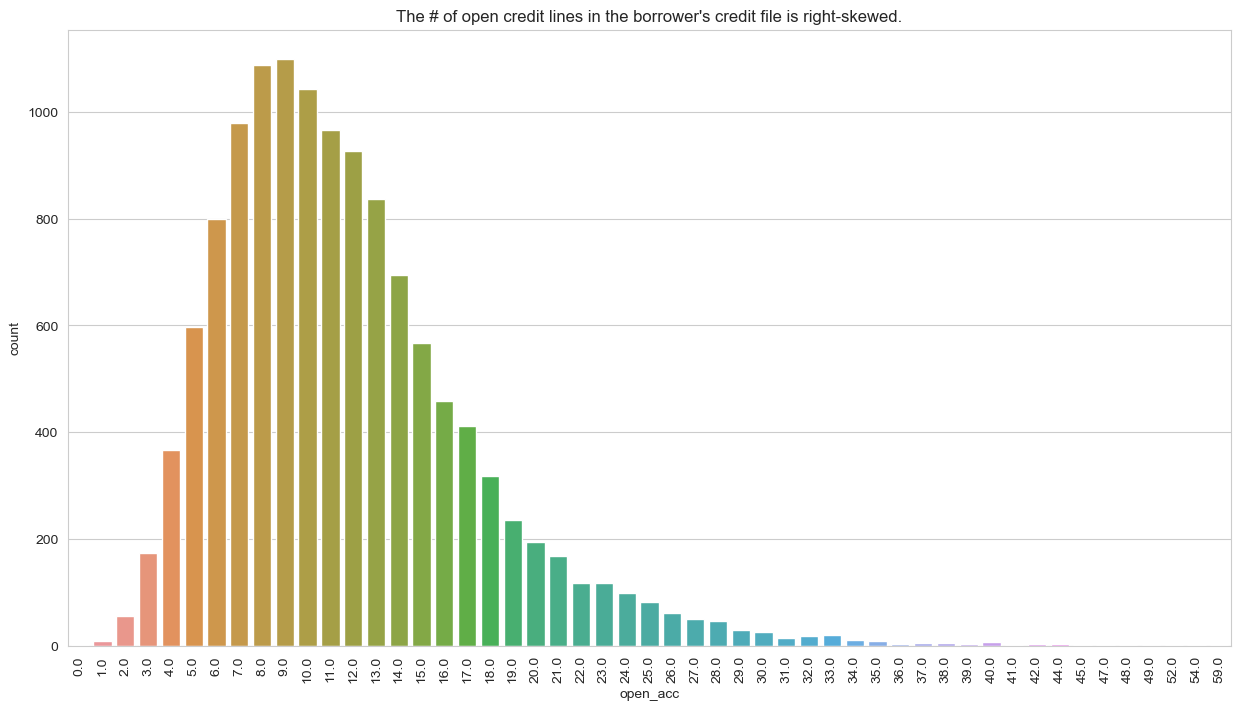

In [86]:
plt.figure(figsize=(15, 8))
plt.xticks(rotation=90)
ax = sns.countplot(x="open_acc", data=LoanStatData, dodge=False)
ax.set(title="The # of open credit lines in the borrower's credit file is right-skewed.")
plt.savefig('LOL', dpi= 300)

[Text(0.5, 1.0, 'Total credit revolving amount is right-skewed')]

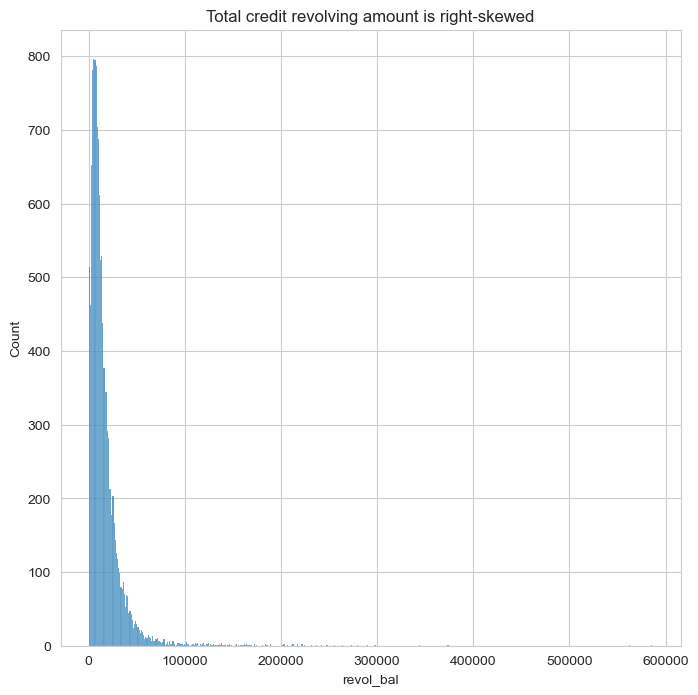

In [87]:
plt.figure(figsize=(8, 8))
ax = sns.histplot(x="revol_bal", data=LoanStatData)
ax.set(title="Total credit revolving amount is right-skewed")


In [88]:
#taking top 50 employment titles.
top_emp_titles = set(LoanStatData.emp_title.value_counts()[:50].index.values) - {''}

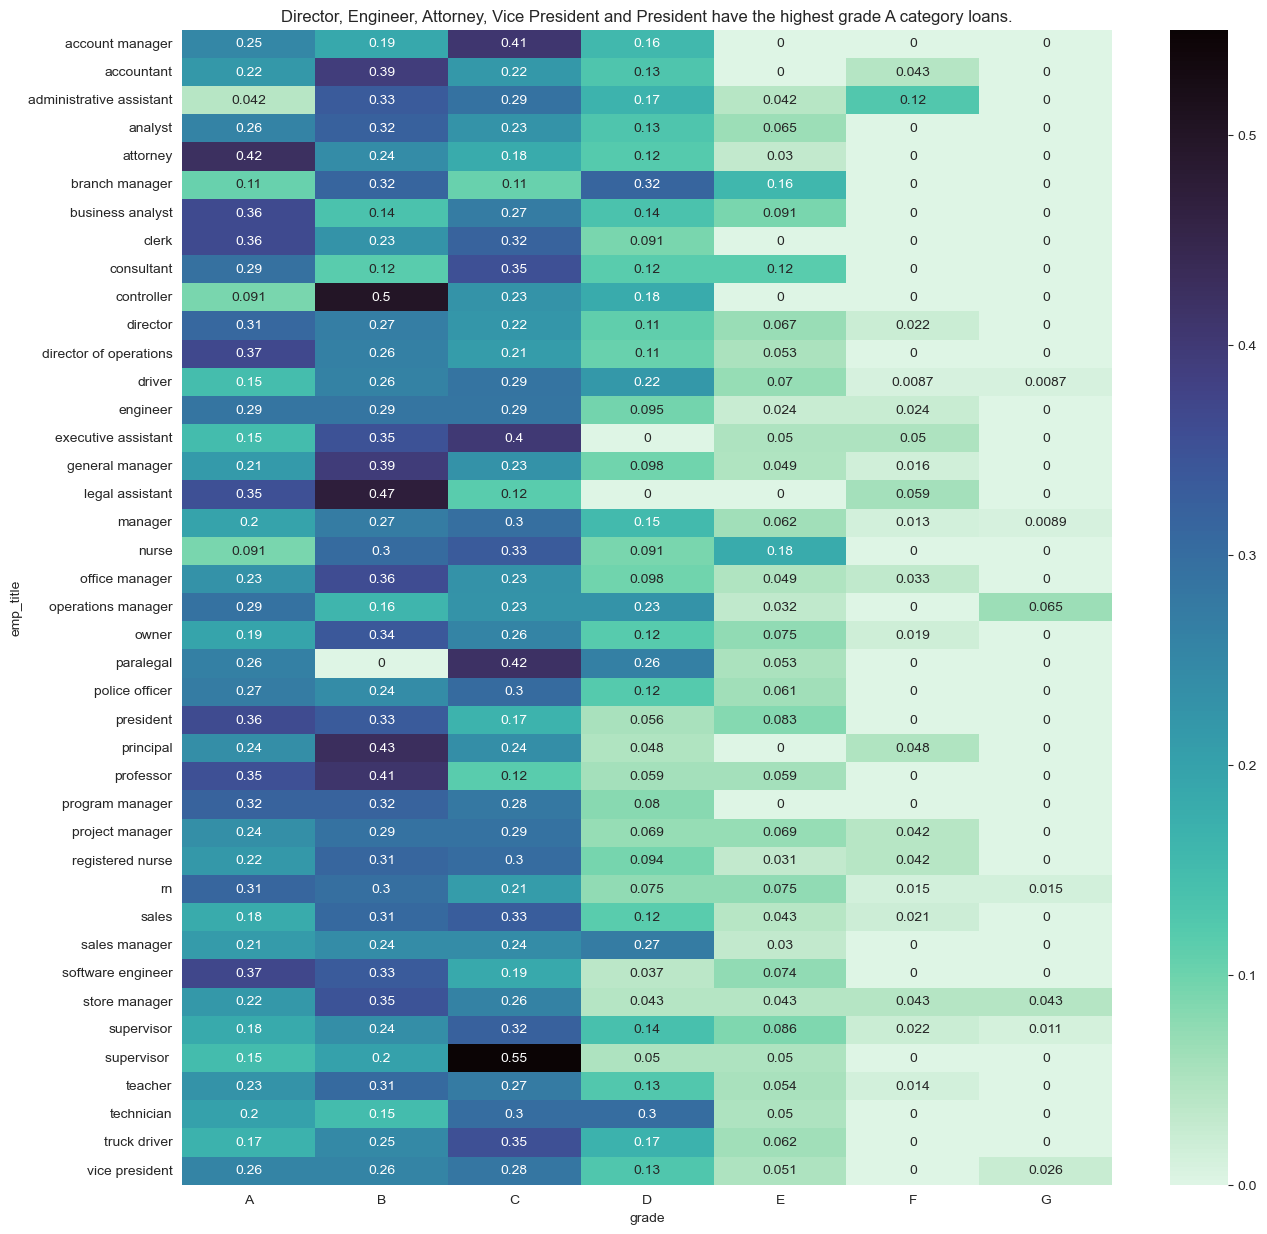

In [89]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(pd.crosstab(LoanStatData[LoanStatData['emp_title'].isin(top_emp_titles)]['emp_title'].str.lower(),
                             LoanStatData[LoanStatData['emp_title'].isin(top_emp_titles)]['grade'],
                             normalize='index'),
                 annot=True,
                 cmap="mako_r")
ax.set(title="Director, Engineer, Attorney, Vice President and President have the highest grade A category loans.")
plt.savefig('heatmap.jpg', dpi=300)

[Text(0.5, 1.0, 'Distribution of loan amount through a the years')]

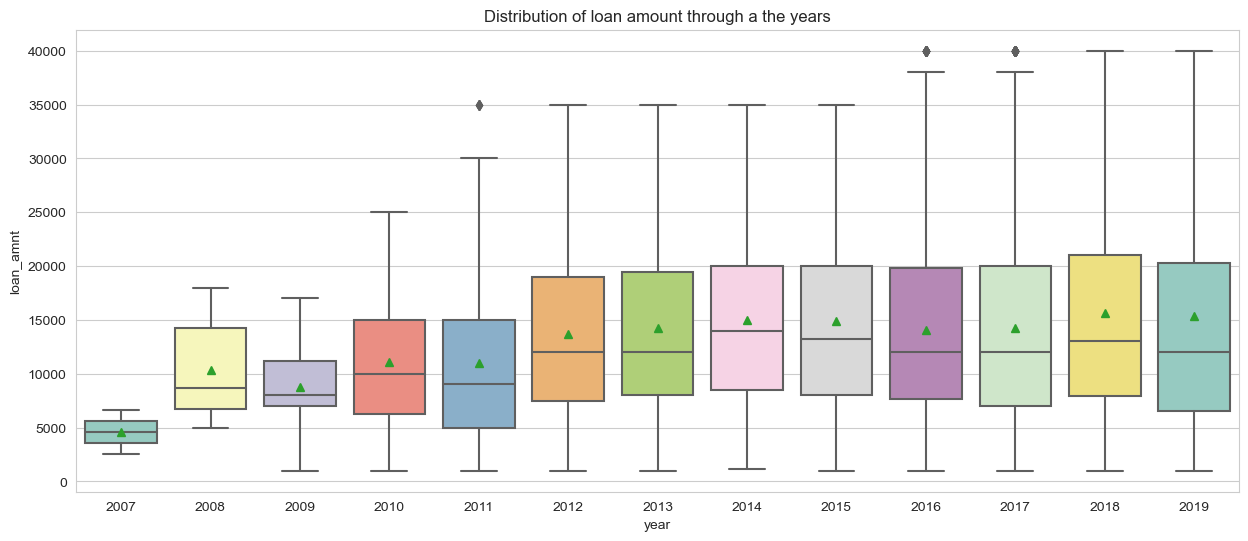

In [90]:
plt.figure(figsize=(15, 6))
ax = sns.boxplot(x="year", y="loan_amnt", palette="Set3",
                 data=LoanStatData[LoanStatData['year'] != 2020], showmeans=True)
ax.set(title="Distribution of loan amount through a the years")

In [91]:
bins = [600, 650, 700, 750, 800, 850]
LoanStatData['fico_bins'] = pd.cut(LoanStatData['fico'], bins).astype('str')

[Text(0.5, 1.0, 'Interest rates over the years (for different fico score ranges)')]

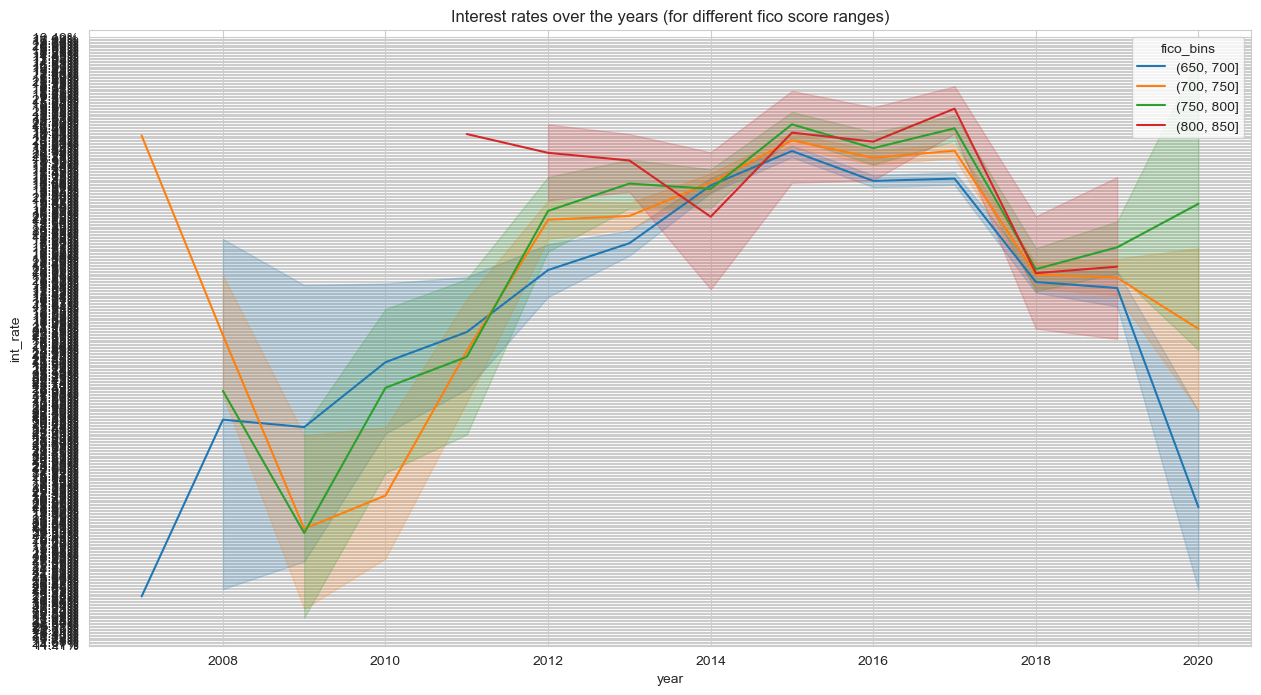

In [92]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(data=LoanStatData, x="year", y="int_rate", hue="fico_bins")
ax.set(title="Interest rates over the years (for different fico score ranges)")

In [93]:
LoanStatData[LoanStatData['fico_bins'] == '(600, 650]'].year


Series([], Name: year, dtype: int64)

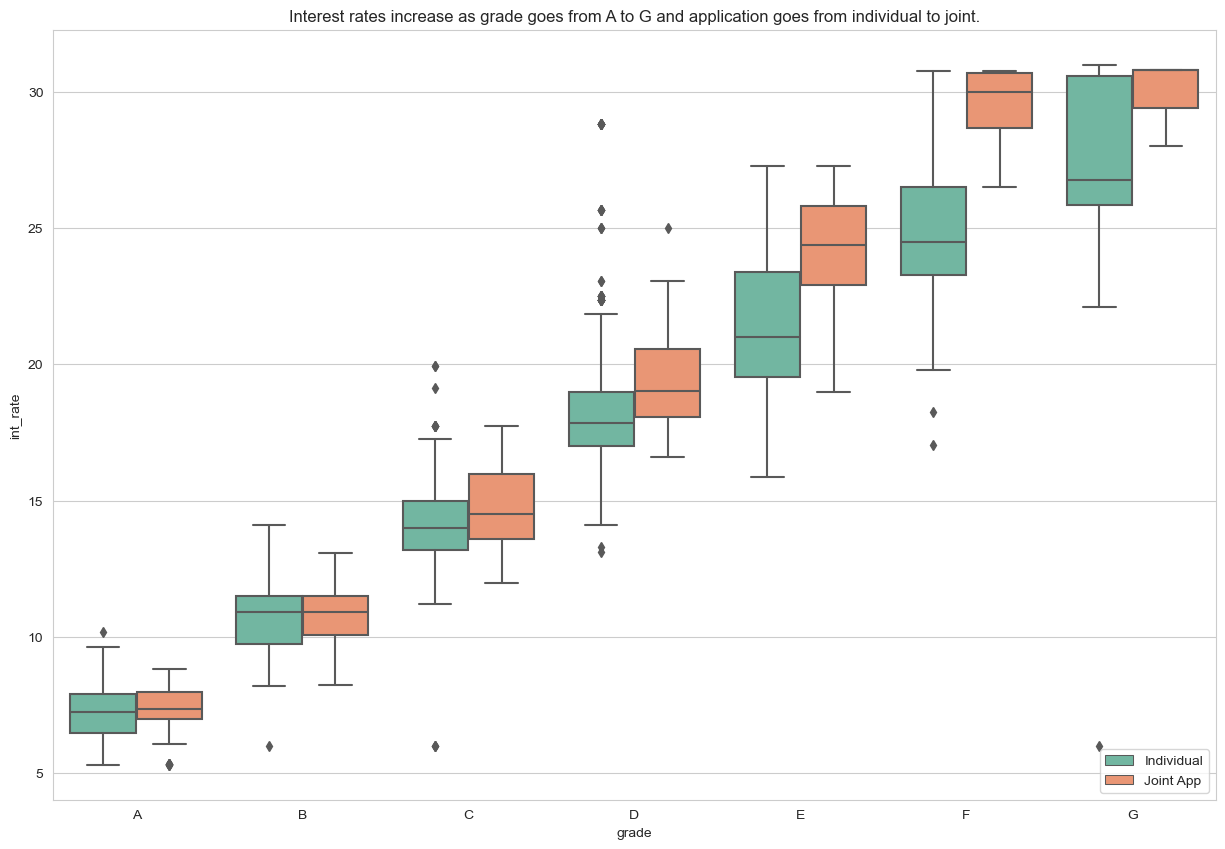

In [94]:
plt.figure(figsize=(15, 10))
# LoanStatData["int_rate"] = LoanStatData['int_rate'].str.replace(' ', '')
LoanStatData['int_rate'] = LoanStatData['int_rate'].apply(lambda x: float(x.split()[0].replace('%', '')))
# LoanStatData['int_rate'] = LoanStatData['int_rate'].astype('float')

ax = sns.boxplot(x="grade", y="int_rate", hue="application_type", palette="Set2",
                 order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                 data=LoanStatData)
ax.set(title="Interest rates increase as grade goes from A to G and application goes from individual to joint.")
plt.legend(loc='lower right')
plt.savefig('interesst rate', dpi= 300)

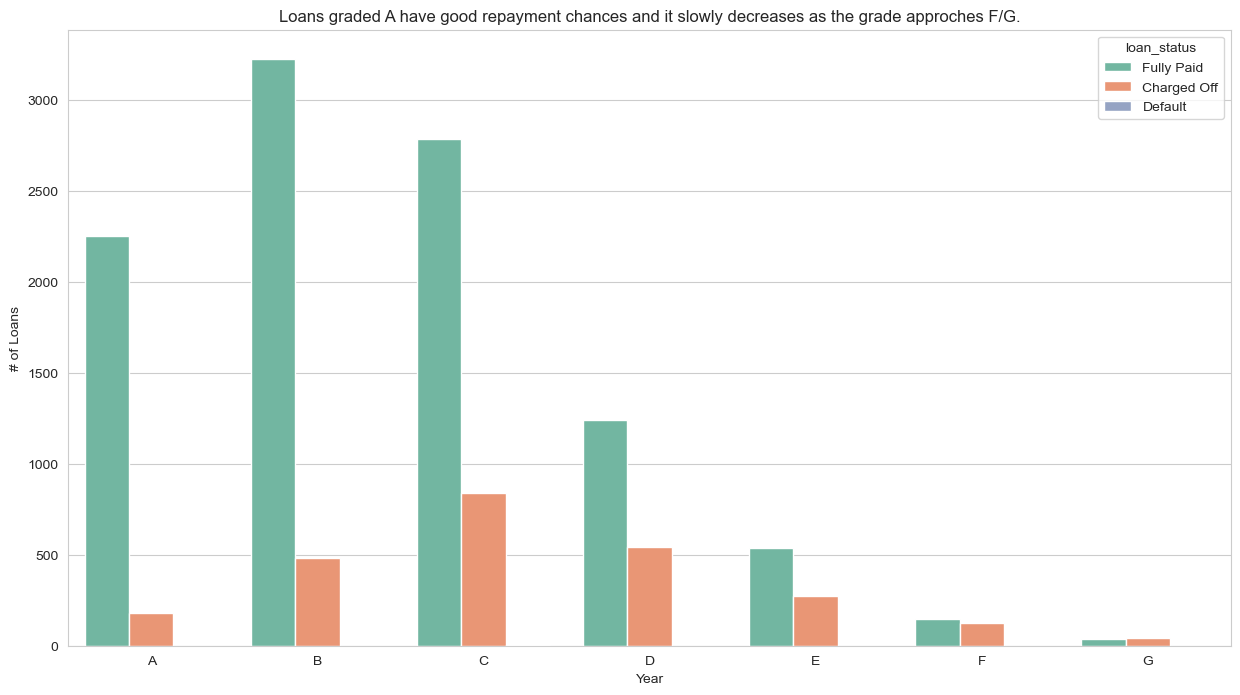

In [95]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x="grade", hue="loan_status", data=LoanStatData, palette="Set2",
                   order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
ax.set(xlabel='Year', ylabel='# of Loans',
       title="Loans graded A have good repayment chances and it slowly decreases as the grade approches F/G.")
plt.savefig('payment chances', dpi= 300)

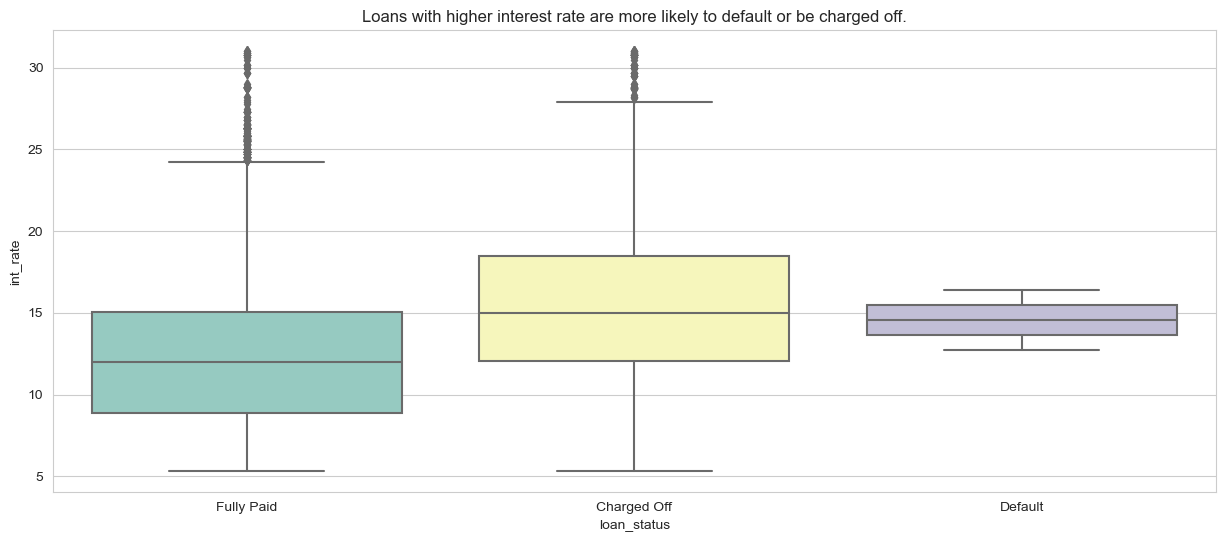

In [96]:
plt.figure(figsize=(15, 6))
ax = sns.boxplot(x="loan_status", y="int_rate", palette="Set3", data=LoanStatData)
ax.set(title="Loans with higher interest rate are more likely to default or be charged off.")
plt.savefig('higher interest reate', dpi=300)

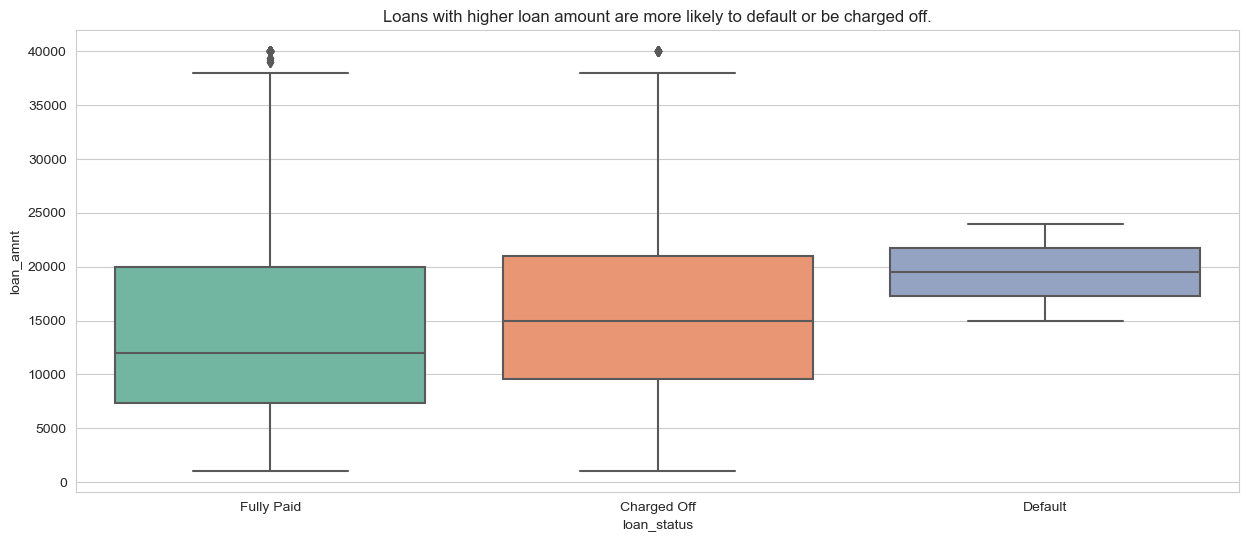

In [97]:
plt.figure(figsize=(15, 6))
ax = sns.boxplot(x="loan_status", y="loan_amnt", palette="Set2", data=LoanStatData)
ax.set(title="Loans with higher loan amount are more likely to default or be charged off.")
plt.savefig('higher amount reate', dpi=300)

In [98]:
#MODELING

In [99]:
# Only keeping verified data form trainning Data.
LoanStatData = LoanStatData[LoanStatData['verification_status'].isin(['Verified', 'Source Verified'])]

In [100]:
row_count = len(LoanStatData)

In [101]:
na_count = LoanStatData.isnull().sum()

In [102]:
l = []
for col_name, count in na_count.iteritems():
    l.append([col_name, count, int((count/row_count) * 100)])

na_df = pd.DataFrame(columns=['col_name', 'count', 'percent'], data = l)

In [103]:
pd.set_option('display.max_rows', 500)

In [104]:
LoanStatData.drop(na_df[na_df.percent >= 90].col_name.to_list(), axis=1, inplace=True)

In [105]:
fill_with_0s = ['max_bal_bc', 'mort_acc', 'mths_since_last_major_derog', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'open_rv_12m', 'open_rv_24m', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bal_il', 'total_il_high_credit_limit', 'total_rev_hi_lim', 'total_cu_tl']


In [106]:
remove = ['all_util', 'hardship_flag', 'total_bc_limit', 'Unnamed: 0']

In [107]:
fill_with_neg1 = ['mths_since_last_delinq', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq']

In [108]:
# Removing columns that we dont want to keep.
LoanStatData.drop(remove, axis=1, inplace=True)

In [109]:
# Filling NaNs with 0s.
for col in fill_with_0s:
    LoanStatData[col].fillna(0, inplace=True)

In [110]:
# Filling NaNs with -1.
for col in fill_with_neg1:
    LoanStatData[col].fillna(-1, inplace=True)

In [111]:
# Creating target variable.
LoanStatData['default'] = LoanStatData['loan_status'].map({'Fully Paid':0,'Charged Off':1, 'Default':1})

In [112]:
LoanStatData['emp_length'].fillna('< 1 year', inplace=True)
LoanStatData['emp_title'].fillna('', inplace=True)
LoanStatData['last_credit_pull_d'].fillna('', inplace=True)
LoanStatData['last_pymnt_d'].fillna('', inplace=True)
LoanStatData['title'].fillna('', inplace=True)
LoanStatData['zip_code'].fillna('xxxxx', inplace=True)

In [113]:
LoanStatData = LoanStatData.set_index(['id'], drop=True)

In [114]:
# Columns to keep.
keep = ['year',
        'avg_cur_bal',
        'default',
        'fico',
        'loan_amnt',
        'term',
        'int_rate',
        'installment',
        'sub_grade',
        'emp_length',
        'home_ownership',
        'annual_inc',
        'purpose',
        'addr_state',
        'dti',
        'earliest_cr_line',
        'inq_last_6mths',
        'open_acc',
        'pub_rec',
        'initial_list_status',
        'mths_since_last_major_derog',
        'application_type',
        'acc_now_delinq',
        'tot_cur_bal',
        'open_acc_6m',
        'open_act_il',
        'open_il_12m',
        'mths_since_rcnt_il',
        'total_bal_il',
        'open_rv_12m',
        'max_bal_bc',
        'total_cu_tl',
        'mo_sin_old_il_acct',
        'mo_sin_old_rev_tl_op',
        'mo_sin_rcnt_rev_tl_op',
        'mo_sin_rcnt_tl',
        'mort_acc',
        'mths_since_recent_bc',
        'mths_since_recent_revol_delinq',
        'num_actv_rev_tl',
        'num_il_tl',
        'pct_tl_nvr_dlq',
        'pub_rec_bankruptcies']


In [115]:
drop_cols = set(LoanStatData.columns.to_list()) - set(keep)

In [116]:
LoanStatData.drop(drop_cols, axis=1, inplace=True)

In [117]:
# Use this dictionary to change emp_length to integer
emp_len_map = {
    '10+ years' : 10,
    '< 1 year' : 0,
    '1 year' : 1,
    '3 years' : 3,
    '9 years' : 9,
    '4 years' : 4,
    '2 years' : 2,
    '7 years' : 7,
    '5 years' : 5,
    '6 years' : 6,
    '8 years' : 8
}

In [118]:
# Changing emp_length to integer.
LoanStatData['emp_length'] = LoanStatData.apply(lambda r: emp_len_map[r.emp_length], axis=1)

In [119]:
# Keeping only the year and removing the month.
LoanStatData['earliest_cr_line']  = LoanStatData.apply(lambda r: int(r['earliest_cr_line'][-4:]), axis=1)

In [120]:
# One-hot encoding
for feature, prefix in zip(['term', 'purpose', 'sub_grade'],
                           ['TERM', 'PURPOSE', 'SUB_GRADE']):
    dummy = pd.get_dummies(LoanStatData[feature], prefix=prefix, drop_first=True)
    LoanStatData = pd.concat([LoanStatData, dummy], axis=1)
    LoanStatData = LoanStatData.drop(feature, axis=1)

In [121]:
# Label Encoding
label_encoder = LabelEncoder()

for feature in ['home_ownership', 'addr_state', 'initial_list_status', 'application_type']:
    LoanStatData[feature]= label_encoder.fit_transform(LoanStatData[feature])

In [122]:
# Feature Engineering: New variable monthly_load = percent of income that goes in installment.
LoanStatData['monthly_load'] = LoanStatData.apply(
    lambda r: ((r.installment * 12) / r.annual_inc) * 100 if r.annual_inc != 0 else -1,
    axis=1)

In [123]:
# Log transform very right-skewed data.
LoanStatData['annual_inc'] = np.log(LoanStatData['annual_inc'] + 1)
LoanStatData['open_acc'] = np.log(LoanStatData['open_acc'] + 1)

In [124]:
# Split into train/test before imputing missing values with median.
X = LoanStatData.drop('default', axis=1)
y = LoanStatData['default']
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state=1)

In [125]:
X_train['dti'].fillna(X_train['dti'].median(), inplace=True)
X_train['dti']

id
105740523    25.29
1118876      18.02
101135053    30.96
56522232     18.63
61792378     15.66
             ...  
43165509     35.15
70992327     12.09
128128243    18.90
38699503     39.78
7389146      16.41
Name: dti, Length: 6911, dtype: float64

In [126]:

ros = RandomUnderSampler(random_state=1)
X_train_new, y_train_new = ros.fit_resample(X_train, y_train)
X_train_new


,loan_amnt,int_rate,installment,emp_length,home_ownership,annual_inc,addr_state,dti,earliest_cr_line,inq_last_6mths,...,SUB_GRADE_F2,SUB_GRADE_F3,SUB_GRADE_F4,SUB_GRADE_F5,SUB_GRADE_G1,SUB_GRADE_G2,SUB_GRADE_G3,SUB_GRADE_G4,SUB_GRADE_G5,monthly_load
0,9000.0,8.39,283.65,3,1,11.002117,24,19.90,2006,1.0,...,0,0,0,0,0,0,0,0,0,5.673000
1,7200.0,9.17,229.53,10,1,11.461643,33,9.04,1999,0.0,...,0,0,0,0,0,0,0,0,0,2.899326
2,10000.0,13.33,338.54,4,4,11.680446,4,11.03,1996,0.0,...,0,0,0,0,0,0,0,0,0,3.435908
3,35000.0,10.49,1137.43,10,1,11.972254,42,34.44,1994,0.0,...,0,0,0,0,0,0,0,0,0,8.622337
4,25000.0,16.91,620.11,2,5,11.112463,15,30.13,2007,0.0,...,0,0,0,0,0,0,0,0,0,11.106448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,24300.0,11.99,807.00,0,5,11.143614,4,6.88,1993,0.0,...,0,0,0,0,0,0,0,0,0,14.010417
2940,15250.0,30.75,653.67,3,1,10.703267,41,38.97,2011,1.0,...,0,0,0,1,0,0,0,0,0,17.627056
2941,18000.0,10.49,584.96,10,5,11.097425,4,18.84,1997,0.0,...,0,0,0,0,0,0,0,0,0,10.635636
2942,11800.0,19.52,309.49,3,5,10.200290,4,35.15,2000,0.0,...,0,0,0,0,0,0,0,0,0,13.801115


In [127]:
dmatrix = xgb.DMatrix(data=X_train_new, label=y_train_new, feature_names=X.columns.to_list())

In [128]:
xgb_trained = xgb.train(params={'objective':"reg:logistic",
                                'seed':1},
                        dtrain=dmatrix)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

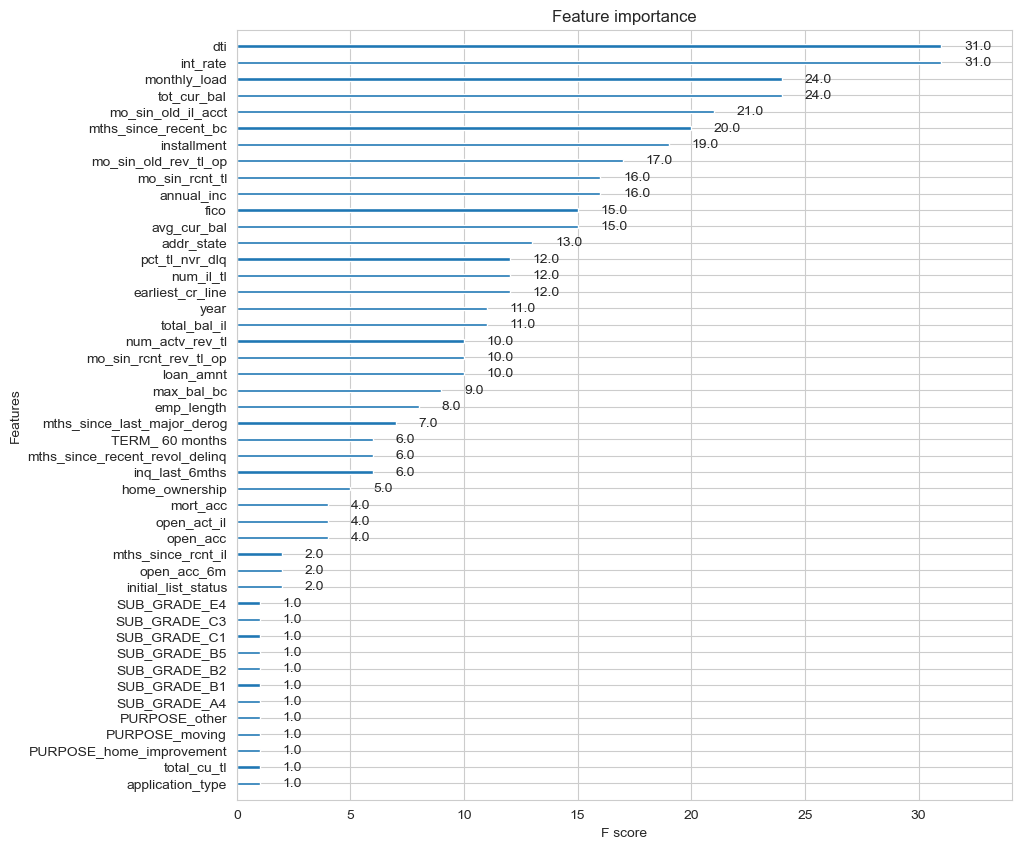

In [129]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(xgb_trained, ax=ax)

In [130]:
drop_cols = list(set(LoanStatData.columns) -
                 set(['year', 'monthly_load',
                      'int_rate', 'avg_cur_bal',  'TERM 60 months', 'fico',
                      'dti', 'mo_sin_old_rev_tl_op', 'annual_inc', 'emp_length', 'num_actv_rev_tl',
                      'home_ownership']))

In [131]:
# Split into train/test before imputing missing values with median.
X = LoanStatData.drop(drop_cols, axis=1)
y = LoanStatData['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [132]:
X_train['dti'].fillna(X_train['dti'].median(), inplace=True)

In [133]:
# Handling class imbalance by undersampling.
ros = RandomUnderSampler(random_state=1)
X_train_new, y_train_new = ros.fit_resample(X_train, y_train)

In [134]:
model = xgb.XGBClassifier(objective="reg:logistic", seed=1, use_label_encoder=False)
model.fit(X_train_new, y_train_new)
y_pred = model.predict(X_test)

/Users/ghanshyam/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



In [135]:
accuracy = roc_auc_score(y_test, y_pred)
print("ROC AUC Score: %.2f%%" % (accuracy * 100.0))

ROC AUC Score: 59.36%


In [136]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.57      0.68      1349
           1       0.29      0.62      0.39       379

    accuracy                           0.58      1728
   macro avg       0.56      0.59      0.53      1728
weighted avg       0.72      0.58      0.62      1728



/Users/ghanshyam/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



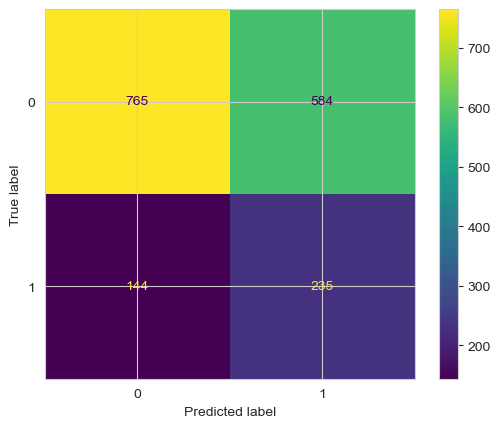

In [137]:
plot_confusion_matrix(model, X_test, y_test)

In [138]:
fpr1, tpr1, threshold1 = roc_curve(y_test, y_pred)
roc_auc1 = auc(fpr1, tpr1)

In [139]:
y_pred_train = model.predict(X_train_new)
fpr2, tpr2, threshold2 = roc_curve(y_train_new, y_pred_train)
roc_auc2 = auc(fpr2, tpr2)

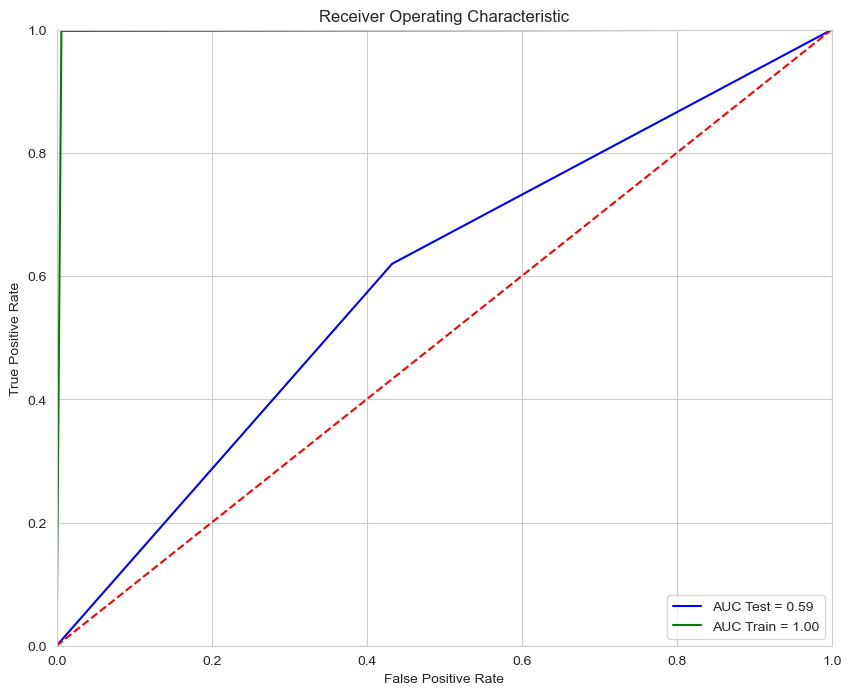

In [140]:
plt.figure(figsize=(10, 8))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC Test = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC Train = %0.2f' % roc_auc2)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()